This code (will be) set up to generate a forecasted impact map of a specified area.
The area in the example case is Houston, TX
The inundation extent is sourced from the National Water Model forecast. 
Depth model is calculated from the inundation extent and the national 3m DEM
The impact map is calculated from the depth and the CDC SVI scores at the census tract scale. 

In [ ]:
# edit code so that it runs automatically every hour
# use python.12.4 kernel
# THIS IS A WORK IN PROGRESS

In [1]:
%pip install geopandas requests


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: C:\Users\Lyn\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import requests
import geopandas as gpd

# Construct the query URL
# To change the query, you can go to https://maps.water.noaa.gov/server/rest/services/nwm
# Then select the link you want, copy it here, and add /0/query to the end
# e.g. https://link_to_service/0/query
query_url = "https://maps.water.noaa.gov/server/rest/services/nwm/mrf_gfs_5day_max_inundation_extent/MapServer/0/query"
params = {
    'where': '1=1',
    'outFields': '*',
    'outSR': '4326',  # Specify output spatial reference if needed
    'f': 'geojson',  # Request geojson output
    'returnGeometry': 'true'
}

# Make the request
response = requests.get(query_url, params=params)

# Convert to GeoDataFrame
predictions = gpd.GeoDataFrame.from_features(response.json(), crs="EPSG:4326")

print(predictions.head())


                                            geometry feature_id  \
0  MULTIPOLYGON (((-78.62528 41.73424, -78.62492 ...    8973676   
1  MULTIPOLYGON (((-78.63000 41.73752, -78.62997 ...    8973676   
2  MULTIPOLYGON (((-74.61027 43.79164, -74.61019 ...   15469207   
3  MULTIPOLYGON (((-74.62307 43.79365, -74.62310 ...   15469207   
4  MULTIPOLYGON (((-74.66201 43.75491, -74.66222 ...   15469229   

   streamflow_cfs           reference_time              update_time  oid  
0            9.18  2024-06-26 18:00:00 UTC  2024-06-27 00:39:24 UTC    1  
1            9.18  2024-06-26 18:00:00 UTC  2024-06-27 00:39:24 UTC    2  
2           18.72  2024-06-26 18:00:00 UTC  2024-06-27 00:39:24 UTC    3  
3           18.72  2024-06-26 18:00:00 UTC  2024-06-27 00:39:24 UTC    4  
4          189.64  2024-06-26 18:00:00 UTC  2024-06-27 00:39:24 UTC    5  


C:\Users\Lyn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\contextily\tile.py:623: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)
C:\Users\Lyn\AppData\Local\Temp\ipykernel_18328\4089502556.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([round(val, 2) for val in ax.get_xticks()], rotation=45)
C:\Users\Lyn\AppData\Local\Temp\ipykernel_18328\4089502556.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(val, 2) for val in ax.get_yticks()])


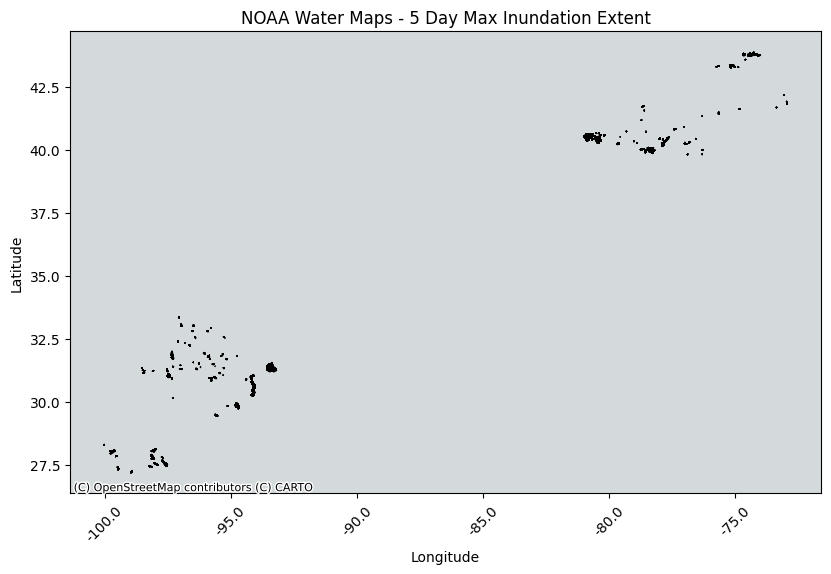

In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt
import contextily as ctx

# Create a subplot with specified figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the predictions GeoDataFrame on the created axes object
# Ensure to specify the ax parameter to plot on the same axes
predictions.plot(ax=ax, color='blue', edgecolor='black')

# Add a basemap to the same axes object
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Adjust x and y axis labels to longitude and latitude
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Convert axis labels to degrees and set rotation for better readability
ax.set_xticklabels([round(val, 2) for val in ax.get_xticks()], rotation=45)
ax.set_yticklabels([round(val, 2) for val in ax.get_yticks()])

# Set plot title and labels for axes
plt.title('NOAA Water Maps - National 5 Day Max Inundation Extent')

# Display the combined plot
plt.show()

In [7]:
from datetime import datetime
# Format the current datetime as a string in the desired format (e.g., YYYYMMDD_HHMMSS)
datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

print(datetime)

20240626_231254


In [8]:
# Export GeoDataFrame as a Shapefile
file_name = f"C:/Users/Lyn/Documents/Programming/Python_codes/Impact_Map_Forecasting/results_5day_forecast/5day_inundationextent_{datetime}.shp"
predictions.to_file(file_name)

C:\Users\Lyn\AppData\Local\Temp\ipykernel_18328\669758952.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  predictions.to_file(file_name)


Turn the shapefile of the inundation forecast into a raster

In [11]:
%pip install osgeo

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable
  Using cached osgeo-0.0.1.tar.gz (1.2 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build osgeo



  error: subprocess-exited-with-error
  
  × Building wheel for osgeo (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [49 lines of output]
      running bdist_wheel
      running build
      installing to build\bdist.win-amd64\wheel
      running install
      Traceback (most recent call last):
        File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\site-packages\

In [1]:
import os
import geopandas as gpd
from osgeo import gdal, ogr, osr

# Set the working directory
os.chdir(r'C:/Users/Lyn/Documents/Programming/Python_codes/Impact_Map_Forecasting/ results_5day_forecast')

# Read the shapefile using GeoPandas
#shapefile = gpd.read_file(r'D:/Hesham/CUAHSI/Geospatial/Jupyter N2/svi_data.shp')

# Open the shapefile using OGR
#input_shp = ogr.Open(r'D:/Hesham/CUAHSI/Geospatial/Jupyter N2/svi_data.shp')
#source_layer = input_shp.GetLayer()
#defn = source_layer.GetLayerDefn()

# Extract column names
column_names = []
for n in range(predictions.GetFieldCount()):
    fdefn = predictions.GetFieldDefn(n)
    column_names.append(fdefn.GetName())

# Define output raster location and pixel size
output_raster_location = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/svi_raster.tif'
pixel_size = 0.0001

# Get extent of the source layer
xmin, xmax, ymin, ymax = predictions.GetExtent()

# Calculate resolution
x_res = int(round((xmax - xmin) / pixel_size))
y_res = int(round((ymax - ymin) / pixel_size))

# Create the target raster file
target_ds = gdal.GetDriverByName('GTiff').Create(output_raster_location, x_res, y_res, 1, gdal.GDT_Float32, ['COMPRESS=LZW'])
target_ds.SetGeoTransform((xmin, pixel_size, 0, ymax, 0, -pixel_size))

# Set projection
srs = osr.SpatialReference()
srs.ImportFromEPSG(4269)  # EPSG:4269 is NAD83
target_ds.SetProjection(srs.ExportToWkt())

# Get the raster band and set NoData value
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(-9999)
band.Fill(-9999)

# Rasterize the shapefile layer to the raster
gdal.RasterizeLayer(target_ds, [1], source_layer, options=['ALL_TOUCHED=TRUE', 'ATTRIBUTE=SVI'])

# Close the raster dataset
target_ds = None

print("Rasterization complete!")


ModuleNotFoundError: No module named 'osgeo'